In [0]:
import random

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, regularizers, optimizers

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [0]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
test_data, test_label = np.array(X_test), np.array(y_test)

In [0]:
def store_database_ref(X_train, y_train):
  '''
  Store 10 training images of each label as a ref for our model
  '''
  ref = np.zeros((10, 28, 28))
  for i in range(10):
    tmp = X_train[y_train == i]
    rd = random.randint(0, len(tmp))
    ref[i] = tmp[rd]
  return ref

In [0]:
img_ref = store_database_ref(X_train, y_train)

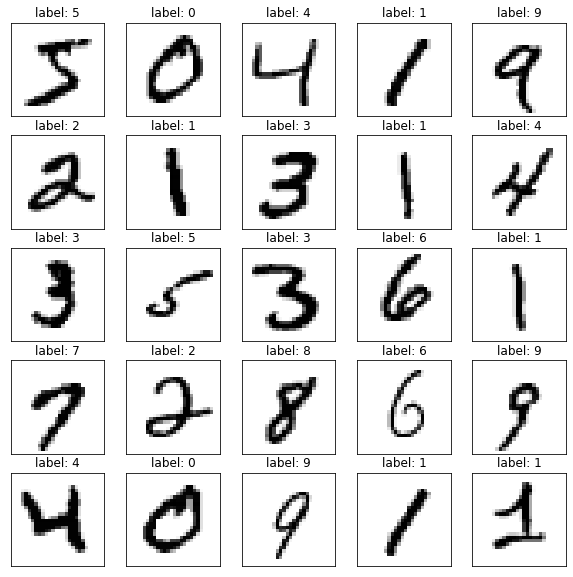

In [174]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.title("label: {}".format(y_train[i]))
plt.show()

In [0]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [0]:
def contrastive_loss(y_true, y_pred):
    '''
    Contrastive loss from Hadsell-et-al.'06
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
## display one batch of data
def display_one_batch(img1, img2, label):
    '''
    Display only one pair of image
    '''
    img1 = np.reshape(img1, (img1.shape[0], img1.shape[1]))
    img2 = np.reshape(img2, (img2.shape[0], img2.shape[1]))

    fig = plt.figure(figsize=(3, 3))
    
    plt.subplot(1, 2, 1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    plt.imshow(img1, cmap=plt.cm.binary)
    plt.title("label: {}".format(label))

    
    plt.subplot(1, 2, 2)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    plt.imshow(img2, cmap=plt.cm.binary)

    plt.title("label: {}".format(label))
    plt.show()


def display_batch(batch_datas, batch_labels):
    '''
    Display the pair of images of the current batch
    '''
    print("Pairs of images")
    for i in range(10):
        display_one_batch(batch_datas[i][0], batch_datas[i][1], batch_labels[i])

In [0]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]

X_train, y_train = create_pairs(X_train, digit_indices)
digit_indices = [np.where(y_test == i)[0] for i in range(10)]
X_test, y_test = create_pairs(X_test, digit_indices)

In [180]:
print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))

Training data shape: (108400, 2, 28, 28)
Testing data shape: (17820, 2, 28, 28)


Pairs of images


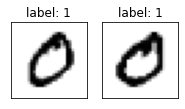

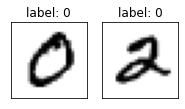

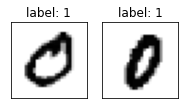

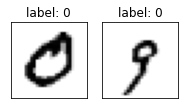

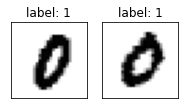

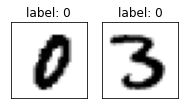

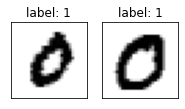

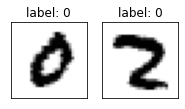

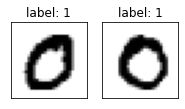

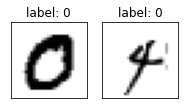

In [181]:
display_batch(X_train, y_train)

In [0]:
def compute_accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
## build the siamese model
def dense_siamese_model():
    '''
    Build a Dense siamese model
    '''
    input_shape = (28, 28)

    inpt = Input(shape=input_shape)
    x = Flatten() (inpt)
    x = Dense(128, activation='relu') (x)
    x = Dropout(0.1) (x)
    x = Dense(128, activation='relu') (x)
    x = Dropout(0.1) (x)
    x = Dense(128, activation='relu') (x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=1)) (x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=1)) (x)
    
    model = Model(inpt, x)

    siamese_a = Input(shape=input_shape)
    siamese_b = Input(shape=input_shape)

    encoded_a = model(siamese_a)
    encoded_b = model(siamese_b)

    distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([encoded_a, encoded_b])

    model = Model([siamese_a, siamese_b], distance)

    adm = Adam(lr=0.002)
    model.compile(loss=contrastive_loss, optimizer=adm, metrics=[accuracy]) ## for metrics: our method is called

    return model

def cnn_siamese_model():
  '''
  Build a CNN siamese model
  '''
  inpt_shape=(28, 28, 1)

  inpt = Input(shape=inpt_shape)
  x = Conv2D(32, (3, 3), activation='relu', input_shape=inpt_shape) (inpt)
  x = MaxPooling2D(2, 2) (x)
  x = Conv2D(64, (3, 3), activation='relu') (x)
  x = MaxPooling2D(2, 2) (x)
  x = Dropout(0.1) (x)
  x = Flatten() (x)
  x = Dense(256, activation='relu') (x) ## encoded data

  x = Lambda(lambda x: K.l2_normalize(x, axis=1)) (x)
  x = Lambda(lambda x: K.l2_normalize(x, axis=1)) (x)
    
  model = Model(inpt, x)

  siamese_a = Input(inpt_shape)
  siamese_b = Input(inpt_shape)

  encoded_a = model (siamese_a)
  encoded_b = model (siamese_b)

  distance = Lambda(euclidean_distance,
                    output_shape=eucl_dist_output_shape) ([encoded_a, encoded_b])
  
  model = Model([siamese_a, siamese_b], distance)
  
  adm = Adam(lr=0.002)
  model.compile(loss=contrastive_loss, optimizer=adm, metrics=[accuracy]) ## our accuracy method

  return model

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)

In [185]:
print("Train data shape: {}".format(X_train.shape))
print("Validation data shape: {}".format(X_val.shape))

Train data shape: (86720, 2, 28, 28)
Validation data shape: (21680, 2, 28, 28)


In [187]:
## create the dense model
model_dense = dense_siamese_model()

history = model_dense.fit([X_train[:, 0], X_train[:, 1]], y_train,
          batch_size=128,
          epochs=5,
          validation_data=([X_val[:, 0], X_val[:, 1]], y_val))

Train on 86720 samples, validate on 21680 samples
Epoch 1/5
86720/86720 [==============================] - 8s 95us/sample - loss: 0.0743 - accuracy: 0.9103 - val_loss: 0.0389 - val_accuracy: 0.9548
Epoch 2/5
86720/86720 [==============================] - 7s 82us/sample - loss: 0.0345 - accuracy: 0.9612 - val_loss: 0.0269 - val_accuracy: 0.9693
Epoch 3/5
86720/86720 [==============================] - 7s 82us/sample - loss: 0.0259 - accuracy: 0.9696 - val_loss: 0.0213 - val_accuracy: 0.9746
Epoch 4/5
86720/86720 [==============================] - 7s 82us/sample - loss: 0.0214 - accuracy: 0.9747 - val_loss: 0.0175 - val_accuracy: 0.9791
Epoch 5/5
86720/86720 [==============================] - 7s 83us/sample - loss: 0.0189 - accuracy: 0.9773 - val_loss: 0.0171 - val_accuracy: 0.9787


In [188]:
## create the cnn model
model_cnn = cnn_siamese_model()

n_tr = X_train.shape[0]
n_val = X_val.shape[0]
n_te = X_test.shape[0]

X_train_bis = np.array(X_train)
X_val_bis = np.array(X_val)
X_test_bis = np.array(X_test)

X_train_bis = np.reshape(X_train_bis, (n_tr, 2, 28, 28, 1))
X_val_bis = np.reshape(X_val_bis, (n_val, 2, 28, 28, 1))
X_test_bis = np.reshape(X_test_bis, (n_te, 2, 28, 28, 1))

history = model_cnn.fit([X_train_bis[:, 0], X_train_bis[:, 1]], y_train,
          batch_size=128,
          epochs=5,
          validation_data=([X_val_bis[:, 0], X_val_bis[:, 1]], y_val))

Train on 86720 samples, validate on 21680 samples
Epoch 1/5
86720/86720 [==============================] - 143s 2ms/sample - loss: 0.0439 - accuracy: 0.9637 - val_loss: 0.0199 - val_accuracy: 0.9857
Epoch 2/5
86720/86720 [==============================] - 142s 2ms/sample - loss: 0.0181 - accuracy: 0.9884 - val_loss: 0.0140 - val_accuracy: 0.9914
Epoch 3/5
86720/86720 [==============================] - 142s 2ms/sample - loss: 0.0137 - accuracy: 0.9919 - val_loss: 0.0117 - val_accuracy: 0.9933
Epoch 4/5
86720/86720 [==============================] - 142s 2ms/sample - loss: 0.0115 - accuracy: 0.9943 - val_loss: 0.0106 - val_accuracy: 0.9936
Epoch 5/5
86720/86720 [==============================] - 145s 2ms/sample - loss: 0.0100 - accuracy: 0.9951 - val_loss: 0.0096 - val_accuracy: 0.9946


In [190]:
# compute the accuracy of detecting similar images for the dense model
pred = model_dense.predict([X_test[:, 0], X_test[:, 1]])
test_acc = compute_accuracy(y_test, pred)

print('* Accuracy of Dense model on test set: %0.2f%%' % (100 * test_acc))

* Accuracy of Dense model on test set: 97.22%


In [191]:
# compute the accuracy of detecting similar images for the cnn model
pred = model_cnn.predict([X_test_bis[:, 0], X_test_bis[:, 1]])
test_acc = compute_accuracy(y_test, pred)

print('* Accuracy of CNN model on test set: %0.2f%%' % (100 * test_acc))

* Accuracy of CNN model on test set: 98.97%


In [0]:
def display_pred(test_img, similar_img):
  '''
  Display the test images and the image our classifier said similar
  '''
  test_img = np.reshape(test_img, (28, 28))
  similar_img = np.reshape(similar_img, (28, 28))

  fig = plt.figure(figsize=(3, 3))

  plt.subplot(1, 2, 1)
  plt.yticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(test_img, cmap=plt.cm.binary)
  plt.title("Test image")

  
  plt.subplot(1, 2, 2)
  plt.yticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(similar_img, cmap=plt.cm.binary)

  plt.title("Similar to")
  plt.show()

In [0]:
def predict_real(model, te_x, te_y, ref):
  '''
  Predict data according to the ref
  '''
  n = len(te_y)
  nb_ref = len(ref)
  true = 0
  miss = 0
  for i in range(n):
    prob = np.zeros(nb_ref)
    for j in range(nb_ref):
      prob[j] = model.predict([[te_x[i],], [ref[j],]])
    tmp = np.argmin(prob)
    if (tmp != te_y[i]):
      miss += 1
      print()
      print("Misclassification nb {}".format(miss))
      display_pred(te_x[i], ref[tmp])
    true += (tmp == te_y[i])
  return true / n


Misclassification nb 1


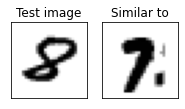


Misclassification nb 2


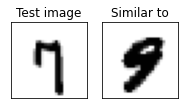


Misclassification nb 3


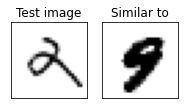


Misclassification nb 4


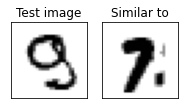


Dense Model Accuracy: 0.98


In [202]:
## make a prediction for the dense model
## display the misclassification
acc = predict_real(model_dense, test_data[:200], test_label[:200], img_ref)
print()
print("Dense Model Accuracy: {}".format(acc))


Misclassification nb 1


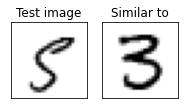


Misclassification nb 2


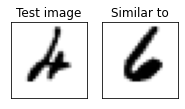


Misclassification nb 3


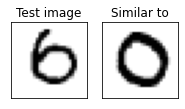


CNN Model accuracy: 0.99


In [204]:
## make a prediction for the cnn model
## display the misclassification
n = test_data.shape[0]
test_data_bis = np.array(test_data)
test_data_bis = np.reshape(test_data_bis, (n, 28, 28, 1))

ref_bis = np.array(img_ref)
ref_bis = np.reshape(ref_bis, (10, 28, 28, 1))

acc = predict_real(model_cnn, test_data_bis[:300], test_label[:300], ref_bis)
print()
print("CNN Model accuracy: {}".format(acc))